In [12]:
#import all essential libraries
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
#import seaborn as sns # used for plot interactive graph. 
from sklearn.metrics import mean_squared_error,r2_score
## Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout
import cPickle as pickle

[[0.2820783  0.2750783  0.14619249 ... 0.14961475 0.1523777  0.28912003]
 [0.28211233 0.27511233 0.14626637 ... 0.14977065 0.15247373 0.28916908]
 [0.28215582 0.2751558  0.14635837 ... 0.14994579 0.15258061 0.2892312 ]
 ...
 [0.55141556 0.43699243 0.03844402 ... 0.19531016 0.74330319 0.96525073]
 [0.55149771 0.43699575 0.03856467 ... 0.19546256 0.74341939 0.96537997]
 [0.551579   0.43699771 0.03866722 ... 0.19559187 0.74352627 0.96549759]]
(4001, 500)
[[ 0.44937546 -0.61891291 -0.82055548]
 [ 0.26983693 -0.84797162 -0.75242619]
 [ 1.48973635 -0.57563286  0.54412952]
 ...
 [ 1.74519437  0.06331114  0.50670615]
 [ 0.98609362  0.26275962  0.47722744]
 [ 1.12882512  0.48922905 -0.88616138]]


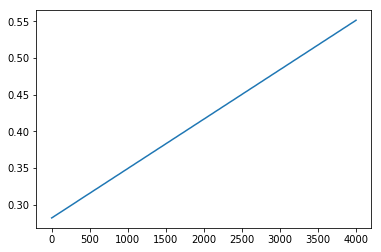

In [35]:
ic_type=0
fname='test'+str(ic_type)+'/' #/non_rd/'
folder_calibs = fname+'calibs'

with open(folder_calibs+'/calib_points_mollified', 'rb') as problem: #
    param_domain = pickle.load(problem)
    physical = pickle.load(problem)
    calibs = pickle.load(problem)
print(calibs)
times=np.arange(0.,physical.T+physical.dt, physical.dt)
[n_param, dim_param] = np.shape(param_domain)

print(calibs.shape)
print(param_domain)
plt.plot(calibs[:,0])
plt.show()

In [36]:

x_dim = dim_param+1 #time

for par in range(n_param):
    for it in range(len(calibs)):
        if calibs[it,par]<0:
            print(2)
n_data = (physical.Nt+1)*n_param

for par in range(n_param):
    adjust_calibs=np.zeros(np.shape(calibs[:,par]))
    shift=0.
    thres=physical.geometry.size_domain/2.
    adjust_calibs[0]=calibs[0,par]
    for k in range(1,len(calibs)):
      if calibs[k,par]-calibs[k-1,par]>thres:
        shift=shift-physical.geometry.size_domain
      elif calibs[k,par]-calibs[k-1,par]<-thres:
        shift=shift+physical.geometry.size_domain
      adjust_calibs[k]=calibs[k,par]+shift
    calibs[:,par]=adjust_calibs

print(calibs.shape)

(4001, 500)


In [14]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


agg = series_to_supervised(calibs)

In [15]:
print(agg)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.282078   0.275078   0.146192   0.190435   0.151506   0.133303   
2      0.282112   0.275112   0.146266   0.190555   0.151626   0.133410   
3      0.282156   0.275156   0.146358   0.190692   0.151758   0.133541   
4      0.282209   0.275209   0.146469   0.190847   0.151902   0.133696   
5      0.282272   0.275272   0.146600   0.191016   0.152055   0.133874   
6      0.282343   0.275343   0.146748   0.191197   0.152216   0.134074   
7      0.282420   0.275420   0.146913   0.191390   0.152384   0.134294   
8      0.282501   0.275500   0.147092   0.191592   0.152557   0.134531   
9      0.282582   0.275580   0.147284   0.191800   0.152734   0.134781   
10     0.282661   0.275657   0.147485   0.192014   0.152913   0.135042   
11     0.282736   0.275728   0.147694   0.192230   0.153094   0.135312   
12     0.282804   0.275791   0.147909   0.192449   0.153275   0.135587   
13     0.282866   0.275844   0.148128 

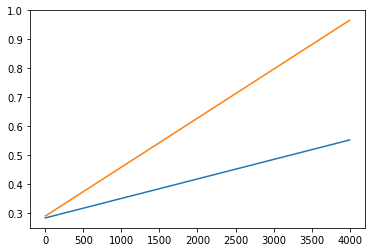

In [73]:
plt.plot(calibs[:,0])
plt.plot(agg["var500(t-1)"])
plt.show()

In [17]:
resampled_data = agg

In [72]:
reframed_data = series_to_supervised(resampled_data, 1, 1)
print(reframed_data.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
2   0.282078   0.275078   0.146192   0.190435   0.151506   0.133303   
3   0.282112   0.275112   0.146266   0.190555   0.151626   0.133410   
4   0.282156   0.275156   0.146358   0.190692   0.151758   0.133541   
5   0.282209   0.275209   0.146469   0.190847   0.151902   0.133696   
6   0.282272   0.275272   0.146600   0.191016   0.152055   0.133874   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var991(t)  var992(t)  \
2   0.291021   0.214435   0.143614    0.282475  ...   0.272696      0.267   
3   0.291034   0.214556   0.143770    0.282583  ...   0.272874      0.267   
4   0.291053   0.214694   0.143945    0.282700  ...   0.273074      0.267   
5   0.291078   0.214850   0.144136    0.282826  ...   0.273294      0.267   
6   0.291112   0.215021   0.144343    0.282959  ...   0.273531      0.267   

   var993(t)  var994(t)  var995(t)  var996(t)  var997(t)  var998(t)  \
2   0.168770   0.248156   0.108364   0.

In [159]:
# split into train and test sets
values = agg.values
train_index = 100 #20*24 #The logic is to have 500 days worth of training data. this could also be a hyperparameter that can be tuned.
train = values[:,:train_index]
test = values[:,train_index:]

# split into input and outputs
i = 0
slice_5=10
train_X=np.zeros((slice_5+3, (4000-slice_5)*train.shape[1]))
train_y=np.zeros(((4000-slice_5)*train.shape[1]))
for k in range(np.shape(train)[1]):
    for j in range(4000-slice_5):
        #print(train[j:j+slice_5,k],param_domain[k])
        train_X[:,i] = np.concatenate((train[j:j+slice_5,k],param_domain[k]))
        train_y[i] = train[j+slice_5,k]
        i = i + 1
        
#train_X, train_y = train[:-5, :], train[-5, :]
"""i = 0
test_X=np.zeros((slice_5+3, (4000-5)*test.shape[1]))
test_y=np.zeros(((4000-5)*test.shape[1]))
for k in range(np.shape(test)[1]):
    for j in range(4000-slice_5):
        #print(train[j:j+slice_5,k],param_domain[k])
        test_X[:,i] = np.concatenate((test[j:j+slice_5,k],param_domain[k]))
        test_y[i] = test[j+slice_5,k]
        i = i + 1
"""        
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[1], 1, train_X.shape[0]))
test_X = test_X.reshape((test_X.shape[1], 1, test_X.shape[0]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].


ValueError: cannot reshape array of size 28764000 into shape (1,1,3595500)

(399500, 1, 8)
Epoch 1/2
399500/399500 [==============================] - 42s 106us/step - loss: 0.0830
Epoch 2/2
399500/399500 [==============================] - 34s 85us/step - loss: 0.0745


KeyError: 'val_loss'

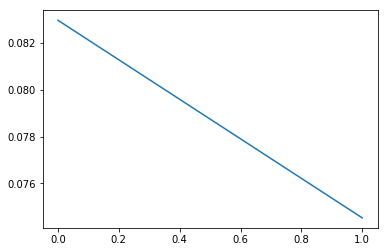

In [152]:
print train_X.shape
model = Sequential()
model.add(LSTM(200, return_sequences=True,input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(Dropout(0.2))
model.add(LSTM(50))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=2, batch_size=512, verbose=1, shuffle=False)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

(3520,)


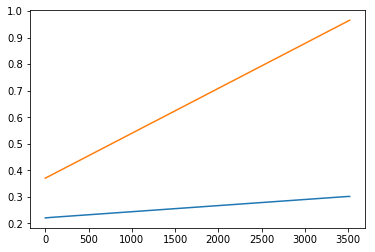

In [102]:
print(test_y.shape)
plt.plot(test_X[:,0,10])
plt.plot(test_y[:])

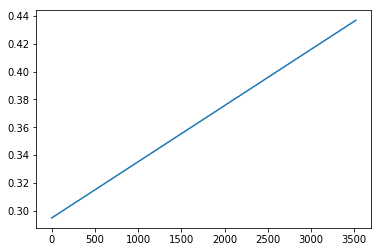

In [110]:
plt.plot(test_X[:,0,1])

In [157]:
# make a prediction
yhat = model.predict(train_X[0:100,:,:], verbose=0)
#rmse = np.sqrt(mean_squared_error(train_y[0:100,:], yhat))
#print('Test RMSE: %.3f' % rmse)


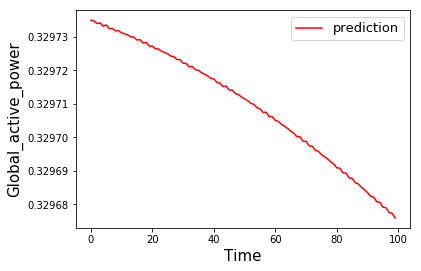

In [158]:
aa=[x for x in range(200)]

#plt.plot(test_y, marker='.', label="actual")
plt.plot(yhat, 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time', size=15)
plt.legend(fontsize=13)
plt.show()